# Credit Risk Modeling - Predicting Default Probability

In [2]:
!pip install ipywidgets --upgrade
!pip install -q xlrd ydata_profiling
!pip install optuna
!pip install ipympl
%matplotlib widget
%matplotlib inline

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import optuna
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from ydata_profiling import ProfileReport

## Loading datasets

In [93]:
credit_risk = pd.read_csv("cs-training.csv")
#test_df = pd.read_csv("/data/cs-test.xls")
#sample_entry = pd.read_csv("/data/sampleEntry.xls")

credit_risk.head()

Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                        0   
1                                4                        0   
2                                2                        1   
3                                5                        0   
4                                7                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                             6                                     0   
1                             0                                     0   
2                             0                                     0   
3                             0                                     0   
4                             1                                     0   

   NumberOfDependents  
0                 2.0  
1                 1.0  
2                 0.0  
3                 0.0  
4                 0.0

## Data cleaning and pre-processing

In [94]:
credit_risk.drop(columns = ['Unnamed: 0'], inplace = True)
credit_risk

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0                      1                              0.766127   45   
1                      0                              0.957151   40   
2                      0                              0.658180   38   
3                      0                              0.233810   30   
4                      0                              0.907239   49   
...                  ...                                   ...  ...   
149995                 0                              0.040674   74   
149996                 0                              0.299745   44   
149997                 0                              0.246044   58   
149998                 0                              0.000000   30   
149999                 0                              0.850283   64   

        NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  MonthlyIncome  \
0                                          2     0.802982         9120.0   
1                                          0     0.121876         2600.0   
2                                          1     0.085113         3042.0   
3                                          0     0.036050         3300.0   
4                                          1     0.024926        63588.0   
...                                      ...          ...            ...   
149995                                     0     0.225131         2100.0   
149996                                     0     0.716562         5584.0   
149997                                     0  3870.000000            NaN   
149998                                     0     0.000000         5716.0   
149999                                     0     0.249908         8158.0   

        NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                                    13                        0   
1                                     4                        0   
2                                     2                        1   
3                                     5                        0   
4                                     7                        0   
...                                 ...                      ...   
149995                                4                        0   
149996                                4                        0   
149997                               18                        0   
149998                                4                        0   
149999                                8                        0   

        NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                                  6                                     0   
1                                  0                                     0   
2                                  0                                     0   
3                                  0                                     0   
4                                  1                                     0   
...                              ...                                   ...   
149995                             1                                     0   
149996                             1                                     0   
149997                             1                                     0   
149998                             0                                     0   
149999                             2                                     0   

        NumberOfDependents  
0                      2.0  
1                      1.0  
2                      0.0  
3                      0.0  
4                      0.0  
...                    ...  
149995                 0.0  
149996                 2.0  
149997                 0.0  
149998                 0.0  
149999                 0.0  

[150000 rows x 11 columns]

In [95]:
# columns description
!pip install xlrd

columns_description = pd.read_excel("Data Dictionary.xls", header=1)
columns_description 

Variable Name  \
0                       SeriousDlqin2yrs   
1   RevolvingUtilizationOfUnsecuredLines   
2                                    age   
3   NumberOfTime30-59DaysPastDueNotWorse   
4                              DebtRatio   
5                          MonthlyIncome   
6        NumberOfOpenCreditLinesAndLoans   
7                NumberOfTimes90DaysLate   
8           NumberRealEstateLoansOrLines   
9   NumberOfTime60-89DaysPastDueNotWorse   
10                    NumberOfDependents   

                                          Description        Type  
0   Person experienced 90 days past due delinquenc...         Y/N  
1   Total balance on credit cards and personal lin...  percentage  
2                            Age of borrower in years     integer  
3   Number of times borrower has been 30-59 days p...     integer  
4   Monthly debt payments, alimony,living costs di...  percentage  
5                                      Monthly income        real  
6   Number of Open loans (installment like car loa...     integer  
7   Number of times borrower has been 90 days or m...     integer  
8   Number of mortgage and real estate loans inclu...     integer  
9   Number of times borrower has been 60-89 days p...     integer  
10  Number of dependents in family excluding thems...     integer

In [96]:
credit_risk.describe()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines            age  \
count     150000.000000                         150000.000000  150000.000000   
mean           0.066840                              6.048438      52.295207   
std            0.249746                            249.755371      14.771866   
min            0.000000                              0.000000       0.000000   
25%            0.000000                              0.029867      41.000000   
50%            0.000000                              0.154181      52.000000   
75%            0.000000                              0.559046      63.000000   
max            1.000000                          50708.000000     109.000000   

       NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  MonthlyIncome  \
count                         150000.000000  150000.000000   1.202690e+05   
mean                               0.421033     353.005076   6.670221e+03   
std                                4.192781    2037.818523   1.438467e+04   
min                                0.000000       0.000000   0.000000e+00   
25%                                0.000000       0.175074   3.400000e+03   
50%                                0.000000       0.366508   5.400000e+03   
75%                                0.000000       0.868254   8.249000e+03   
max                               98.000000  329664.000000   3.008750e+06   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
count                    150000.000000            150000.000000   
mean                          8.452760                 0.265973   
std                           5.145951                 4.169304   
min                           0.000000                 0.000000   
25%                           5.000000                 0.000000   
50%                           8.000000                 0.000000   
75%                          11.000000                 0.000000   
max                          58.000000                98.000000   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
count                 150000.000000                         150000.000000   
mean                       1.018240                              0.240387   
std                        1.129771                              4.155179   
min                        0.000000                              0.000000   
25%                        0.000000                              0.000000   
50%                        1.000000                              0.000000   
75%                        2.000000                              0.000000   
max                       54.000000                             98.000000   

       NumberOfDependents  
count       146076.000000  
mean             0.757222  
std              1.115086  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              1.000000  
max             20.000000

In [97]:
credit_risk.shape

(150000, 11)

### EDA 


The dataset for credit scoring. Historical data are provided on 250,000 borrowers. Target value – wheter a person experienced 90 days past due delinquency or worse (SeriousDlqin2yrs, 1 – did experienct, 0 – did not).

1. 

Empty valu
2. es
Duplicate r
3. ows
Data distribu
4. tion
Correlation between variables and t
5. arget
Compare distributions of train and test features

In [9]:
from ydata_profiling import ProfileReport
ProfileReport(credit_risk, title="Profiling Report for Train Data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [98]:
#drop the duplicates
credit_risk = credit_risk.drop_duplicates()

<Axes: >

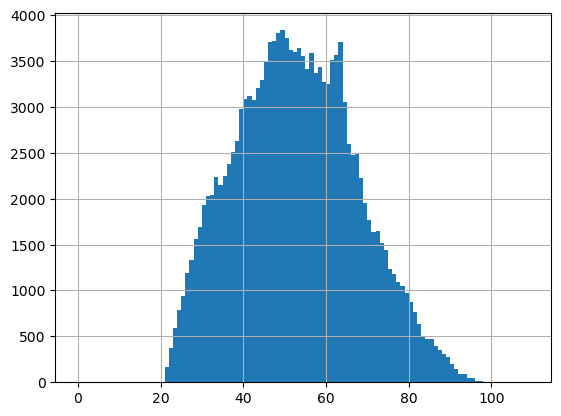

In [99]:

credit_risk["age"].hist(bins=credit_risk["age"].max() - credit_risk["age"].min())


In [100]:
credit_risk.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29221
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3828
dtype: int64

In [101]:
round(credit_risk.isnull().sum()/credit_risk.shape[0]*100,2)

SeriousDlqin2yrs                         0.00
RevolvingUtilizationOfUnsecuredLines     0.00
age                                      0.00
NumberOfTime30-59DaysPastDueNotWorse     0.00
DebtRatio                                0.00
MonthlyIncome                           19.56
NumberOfOpenCreditLinesAndLoans          0.00
NumberOfTimes90DaysLate                  0.00
NumberRealEstateLoansOrLines             0.00
NumberOfTime60-89DaysPastDueNotWorse     0.00
NumberOfDependents                       2.56
dtype: float64

- Age has the highest absolute correlation with target. Drop row from train data where age equals zero, since it obvious outlier and test data has to such records

- 
Columuns RevolvingUtilizationOfUnsecuredLines, NumberOfTime30-59DaysPastDueNotWorse, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans and NumberOfTimes90DaysLate seems to be te are skewed, hence contain outliers, and some preprocessing have to bedone if they are being used in a linear model.m
.-
-  
Column MonthlyIncome has about 20% of missing data. Fill those values with average MonthlyIncombased on the debtratio.n

-
t-  .
Column NumberOfDependents has 2.6% of missing data. Fill those value with 0s.

In [102]:
from sklearn.impute import SimpleImputer

si = SimpleImputer(strategy='mean').fit(credit_risk[['MonthlyIncome']])

has_monthly_income_na = credit_risk['MonthlyIncome'].isna()
credit_risk['MonthlyIncome'] = si.transform(credit_risk[['MonthlyIncome']])

credit_risk.loc[has_monthly_income_na, 'DebtRatio'] = credit_risk.loc[has_monthly_income_na, 'DebtRatio']/credit_risk.loc[has_monthly_income_na, 'MonthlyIncome']

C:\Users\D41284976\AppData\Local\Temp\ipykernel_15188\2558401361.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_risk['MonthlyIncome'] = si.transform(credit_risk[['MonthlyIncome']])


In [103]:
credit_risk.isna().sum()

SeriousDlqin2yrs                           0
RevolvingUtilizationOfUnsecuredLines       0
age                                        0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
MonthlyIncome                              0
NumberOfOpenCreditLinesAndLoans            0
NumberOfTimes90DaysLate                    0
NumberRealEstateLoansOrLines               0
NumberOfTime60-89DaysPastDueNotWorse       0
NumberOfDependents                      3828
dtype: int64

In [104]:
credit_risk['NumberOfDependents'] = credit_risk['NumberOfDependents'].fillna(0)

C:\Users\D41284976\AppData\Local\Temp\ipykernel_15188\752154179.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_risk['NumberOfDependents'] = credit_risk['NumberOfDependents'].fillna(0)


In [105]:
credit_risk.isna().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [106]:
credit_risk.shape

(149391, 11)

## Removing Outliers

In [108]:
credit_risk.head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0                 1                              0.766127   45   
1                 0                              0.957151   40   
2                 0                              0.658180   38   
3                 0                              0.233810   30   
4                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                        0   
1                                4                        0   
2                                2                        1   
3                                5                        0   
4                                7                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                             6                                     0   
1                             0                                     0   
2                             0                                     0   
3                             0                                     0   
4                             1                                     0   

   NumberOfDependents  
0                 2.0  
1                 1.0  
2                 0.0  
3                 0.0  
4                 0.0

This is a binary classification problem and our target variable is SeriousDlqin2yr. Let's analyze our dependent and independent features.

In [109]:
credit_risk.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [110]:
credit_risk.groupby(['SeriousDlqin2yrs']).size()/credit_risk.shape[0]

SeriousDlqin2yrs
0    0.933001
1    0.066999
dtype: float64

Our target variable is highly imbalanced so we will perform univariate and bi variate analysis to see any relationships.

### RevolvingUtilizationOfUnsecuredLines 

Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits	percentage


In [111]:
credit_risk.RevolvingUtilizationOfUnsecuredLines.describe()

count    149391.000000
mean          6.071087
std         250.263672
min           0.000000
25%           0.030132
50%           0.154235
75%           0.556494
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

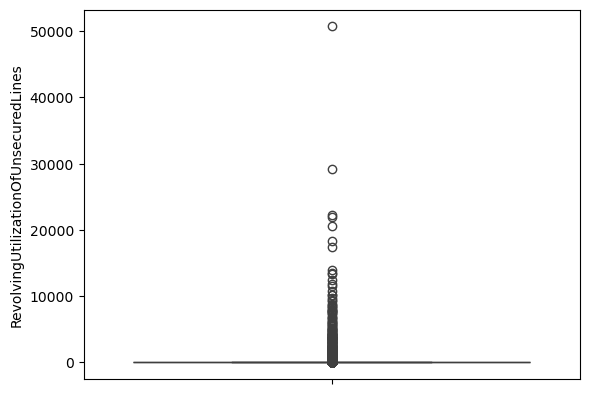

In [112]:
sns.boxplot(credit_risk['RevolvingUtilizationOfUnsecuredLines'])
plt.show()

In [113]:
(credit_risk[credit_risk['RevolvingUtilizationOfUnsecuredLines'] > 10]).describe()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines         age  \
count        241.000000                            241.000000  241.000000   
mean           0.070539                           3564.023932   50.630705   
std            0.256587                           5123.802683   14.565389   
min            0.000000                             11.385230   24.000000   
25%            0.000000                            941.000000   39.000000   
50%            0.000000                           2012.000000   48.000000   
75%            0.000000                           4116.000000   62.000000   
max            1.000000                          50708.000000   87.000000   

       NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  MonthlyIncome  \
count                            241.000000   241.000000     241.000000   
mean                               0.186722    12.815694    7961.882499   
std                                0.579502   157.411198    5615.386256   
min                                0.000000     0.000150       0.000000   
25%                                0.000000     0.129223    5450.000000   
50%                                0.000000     0.266363    6675.098269   
75%                                0.000000     0.435200    8607.000000   
max                                3.000000  2367.000000   44472.000000   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
count                       241.000000               241.000000   
mean                          5.763485                 0.074689   
std                           3.114160                 0.579711   
min                           1.000000                 0.000000   
25%                           4.000000                 0.000000   
50%                           5.000000                 0.000000   
75%                           7.000000                 0.000000   
max                          21.000000                 8.000000   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
count                    241.000000                            241.000000   
mean                       1.186722                              0.087137   
std                        1.065750                              0.559651   
min                        0.000000                              0.000000   
25%                        0.000000                              0.000000   
50%                        1.000000                              0.000000   
75%                        2.000000                              0.000000   
max                        9.000000                              7.000000   

       NumberOfDependents  
count          241.000000  
mean             0.651452  
std              1.022093  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              1.000000  
max              4.000000

In [114]:
credit_risk = credit_risk.drop(credit_risk[credit_risk['RevolvingUtilizationOfUnsecuredLines'] > 10].index)


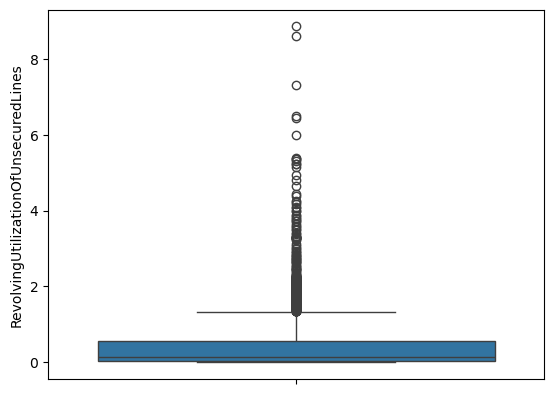

In [115]:
sns.boxplot(credit_risk['RevolvingUtilizationOfUnsecuredLines'])
plt.show()

<Axes: ylabel='age'>

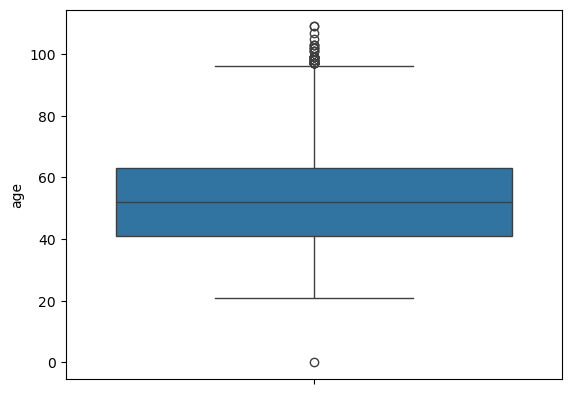

In [116]:
sns.boxplot(credit_risk['age'])

### NumberOfTime30-59DaysPastDueNotWorse

In [117]:
credit_risk.groupby(['NumberOfTime30-59DaysPastDueNotWorse']).size()

NumberOfTime30-59DaysPastDueNotWorse
0     125239
1      16020
2       4588
3       1750
4        747
5        342
6        140
7         54
8         25
9         12
10         4
11         1
12         2
13         1
96         5
98       220
dtype: int64

A sharp jump after 13 to 96 and 98 clearly shows that these are outliers. Before jumping to a conclusion let's analyze two more similar columns. 

### NumberOfTime60-89DaysPastDueNotWorse


In [118]:
credit_risk.groupby(['NumberOfTime60-89DaysPastDueNotWorse']).size()

NumberOfTime60-89DaysPastDueNotWorse
0     141601
1       5723
2       1117
3        318
4        104
5         34
6         16
7          8
8          2
9          1
11         1
96         5
98       220
dtype: int64

### NumberOfTimes90DaysLate

In [119]:
credit_risk.groupby(['NumberOfTimes90DaysLate']).size()

NumberOfTimes90DaysLate
0     140875
1       5227
2       1554
3        666
4        291
5        131
6         80
7         38
8         20
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       220
dtype: int64

In [120]:
(credit_risk[credit_risk['NumberOfTimes90DaysLate']>96]).describe()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines         age  \
count        220.000000                          2.200000e+02  220.000000   
mean           0.600000                          9.999999e-01   36.127273   
std            0.491015                          4.005918e-15   13.283429   
min            0.000000                          9.999999e-01   21.000000   
25%            0.000000                          9.999999e-01   25.000000   
50%            1.000000                          9.999999e-01   31.000000   
75%            1.000000                          9.999999e-01   46.000000   
max            1.000000                          9.999999e-01   79.000000   

       NumberOfTime30-59DaysPastDueNotWorse   DebtRatio  MonthlyIncome  \
count                                 220.0  220.000000     220.000000   
mean                                   98.0    0.005174    4048.967106   
std                                     0.0    0.020441    2969.495160   
min                                    98.0    0.000000       0.000000   
25%                                    98.0    0.000000    1845.750000   
50%                                    98.0    0.000000    3241.500000   
75%                                    98.0    0.001386    6675.098269   
max                                    98.0    0.242193   28733.000000   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
count                       220.000000                    220.0   
mean                          0.009091                     98.0   
std                           0.095128                      0.0   
min                           0.000000                     98.0   
25%                           0.000000                     98.0   
50%                           0.000000                     98.0   
75%                           0.000000                     98.0   
max                           1.000000                     98.0   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
count                         220.0                                 220.0   
mean                            0.0                                  98.0   
std                             0.0                                   0.0   
min                             0.0                                  98.0   
25%                             0.0                                  98.0   
50%                             0.0                                  98.0   
75%                             0.0                                  98.0   
max                             0.0                                  98.0   

       NumberOfDependents  
count          220.000000  
mean             0.386364  
std              0.849816  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              0.000000  
max              5.000000

In [121]:
credit_risk[credit_risk['NumberOfTimes90DaysLate']>=96].groupby(['SeriousDlqin2yrs']).size()

SeriousDlqin2yrs
0     89
1    136
dtype: int64

There are 219 important entries in one column so removing these outliers would result a loss of useful information so let's move to the next column and will see them later.

### DebtRatio

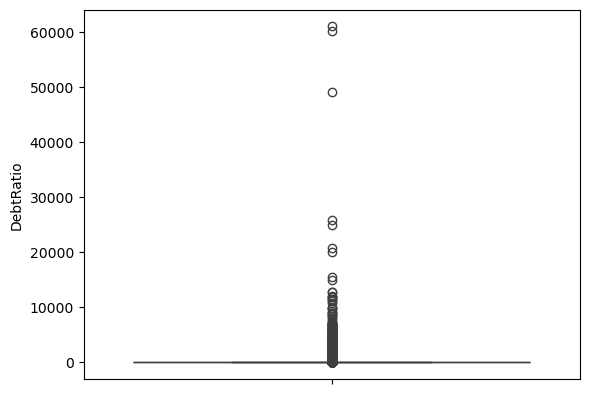

In [122]:
import seaborn as sns

sns.boxplot(credit_risk['DebtRatio'])
plt.show()

In [ ]:
'''

def remove_outliers(df, column_name, iqr_multiplier = 2):
    # TODO check this iqr multiplier default value if it is too stringent
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr
    df = df[(df[column_name] >= lower_bound) & \
            (df[column_name] <= upper_bound)]
    return df

credit_risk = remove_outliers(credit_risk, 'DebtRatio') 

'''

In [123]:
credit_risk['DebtRatio'].describe()

count    149150.000000
mean         21.477517
std         381.233587
min           0.000000
25%           0.116876
50%           0.275397
75%           0.461774
max       61106.500000
Name: DebtRatio, dtype: float64

<Axes: xlabel='DebtRatio', ylabel='Density'>

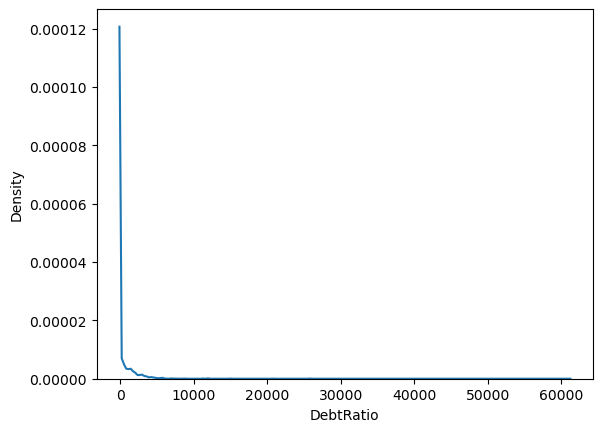

In [124]:
sns.kdeplot(credit_risk['DebtRatio'])

In [125]:
credit_risk['DebtRatio'].quantile([.975])

0.975    1.741186
Name: DebtRatio, dtype: float64

In [126]:
credit_risk[credit_risk['DebtRatio']>3492][['SeriousDlqin2yrs','MonthlyIncome']].describe()

SeriousDlqin2yrs  MonthlyIncome
count        185.000000     185.000000
mean           0.070270       0.064865
std            0.256296       0.246956
min            0.000000       0.000000
25%            0.000000       0.000000
50%            0.000000       0.000000
75%            0.000000       0.000000
max            1.000000       1.000000

In [128]:
credit_risk[(credit_risk['DebtRatio']>3492) & (credit_risk['SeriousDlqin2yrs']==credit_risk['MonthlyIncome'])]

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
90                     0                              0.039388   51   
326                    0                              0.013115   43   
508                    0                              1.000000   73   
844                    0                              0.734284   45   
3370                   0                              1.000000   45   
...                  ...                                   ...  ...   
147094                 0                              0.042575   46   
147286                 0                              0.179077   56   
147424                 0                              0.248989   64   
147523                 0                              0.666509   50   
149673                 0                              0.132362   82   

        NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
90                                         0    15466.0            0.0   
326                                        0     4211.0            0.0   
508                                        0     8500.0            0.0   
844                                        0    11311.0            0.0   
3370                                       0     9260.0            0.0   
...                                      ...        ...            ...   
147094                                     0     3966.0            0.0   
147286                                     0     4630.0            0.0   
147424                                     0     4053.0            0.0   
147523                                     0     4351.0            0.0   
149673                                     0     4123.0            0.0   

        NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
90                                    7                        0   
326                                  21                        0   
508                                   2                        0   
844                                   6                        0   
3370                                  7                        0   
...                                 ...                      ...   
147094                               13                        0   
147286                                6                        0   
147424                               16                        0   
147523                               12                        0   
149673                               14                        0   

        NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
90                                 0                                     0   
326                                2                                     0   
508                                0                                     0   
844                                2                                     1   
3370                               4                                     0   
...                              ...                                   ...   
147094                             2                                     0   
147286                             2                                     0   
147424                             2                                     0   
147523                             2                                     0   
149673                             2                                     0   

        NumberOfDependents  
90                     0.0  
326                    2.0  
508                    0.0  
844                    0.0  
3370                   4.0  
...                    ...  
147094                 2.0  
147286                 2.0  
147424                 0.0  
147523                 2.0  
149673                 0.0  

[164 rows x 11 columns]

In [132]:
credit_risk = credit_risk.drop(credit_risk[(credit_risk['DebtRatio']>3492) & (credit_risk['SeriousDlqin2yrs']==credit_risk['MonthlyIncome'])].index)

After careful investigation we found that there might a some data entry errors in DebtRatio column so we went ahead and dropped records greater than 3792, which have same values in SeriousDlqin2yrs and MonthlyIncome. 

In [134]:
credit_risk.shape

(148986, 11)

### Modeling

Due to a huge class imbalance we will create a tree based model such as Xgboost for this project. You can try different techniques to deal with missing data such as SMOTE and try different models, perform cross validation and hyper parameter tuning for best results.

In [135]:
!pip install Xgboost


from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 2.0 MB/s eta 0:01:03
   ---------------------------------------- 0.1/124.9 MB 1.4 MB/s eta 0:01:27
   ---------------------------------------- 0.2/124.9 MB 1.3 MB/s eta 0:01:36
   ---------------------------------------- 0.2/124.9 MB 1.4 MB/s eta 0:01:31
   ---------------------------------------- 0.3/124.9 MB 1.3 MB/s eta 0:01:39
   ---------------------------------------- 0.3/124.9 MB 1.3 MB/s eta 0:01:36
   ---------------------------------------- 0.4/124.9 MB 1.2 MB/s eta 0:01:40
   ---------------------------------------- 0.4/124.9 MB 1.2 MB/s eta 0:01:42
   ---------------------------------------- 0.5/124.9 MB 1.3 MB/s eta 0:01:37
   ---------------------------------------- 0.5/124.9 MB 1.1 MB/s eta 0:01:55
   ---------------------------------------- 0.6/124.9 MB 1.1 MB/s eta 0:01:53


In [137]:
model = XGBClassifier(tree_method = 'exact')

In [138]:
x = credit_risk.drop(['SeriousDlqin2yrs'],axis=1)
y = credit_risk['SeriousDlqin2yrs']

In [139]:
model.fit(x,y.values.ravel())
y_pred = model.predict(x)

In [140]:
accuracy_score(y,y_pred)

0.9461761507792679

In [141]:
cm = confusion_matrix(y,y_pred)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    138996
           1       0.77      0.28      0.41      9990

    accuracy                           0.95    148986
   macro avg       0.86      0.64      0.69    148986
weighted avg       0.94      0.95      0.93    148986



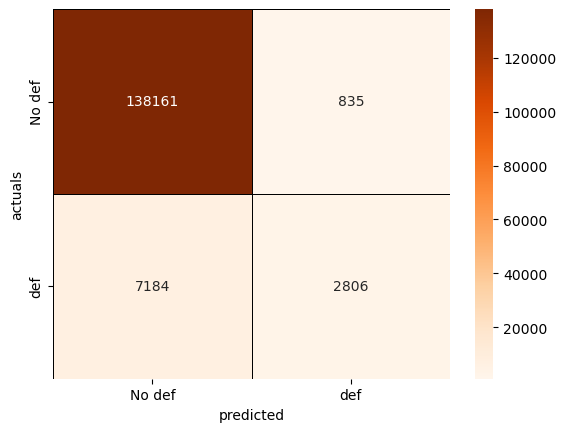

In [142]:
sns.heatmap(cm,annot=True,fmt='d',cmap='Oranges',linewidths=0.5,linecolor='Black')
plt.xticks(np.arange(2)+.5,['No def','def'])
plt.yticks(np.arange(2)+.5,['No def','def'])
plt.xlabel("predicted")
plt.ylabel("actuals")

print(classification_report(y,y_pred))